# Load Libraries and Data

In [9]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import cohen_kappa_score, make_scorer

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [10]:
# Paths to data files
train_csv_path = './data/merged_train.csv'
test_csv_path = './data/merged_test.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Preprocessing

In [11]:
# Separate features and target
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)

X_test = test_df.drop(columns=['id'])

In [12]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fitting LR Model

In [14]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [15]:
# We need to create a list of parameter grids to handle valid combinations
param_grid = [
    # For solvers that support 'multinomial' with 'l2' penalty
    {
        'logreg__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'logreg__penalty': ['l2'],
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__multi_class': ['multinomial'],
        'logreg__class_weight': [None, 'balanced']
    },
    # For 'saga' solver with 'l1' penalty
    {
        'logreg__solver': ['saga'],
        'logreg__penalty': ['l1'],
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__multi_class': ['multinomial'],
        'logreg__class_weight': [None, 'balanced']
    },
    # For 'liblinear' solver with 'l2' and 'l1' penalties (supports only 'ovr')
    {
        'logreg__solver': ['liblinear'],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__multi_class': ['ovr'],
        'logreg__class_weight': [None, 'balanced']
    },
    # For 'saga' solver with 'elasticnet' penalty
    {
        'logreg__solver': ['saga'],
        'logreg__penalty': ['elasticnet'],
        'logreg__l1_ratio': [0.5],  # Elastic net mixing parameter
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__multi_class': ['multinomial'],
        'logreg__class_weight': [None, 'balanced']
    },
    # For 'saga' solver with 'none' penalty
    {
        'logreg__solver': ['saga'],
        'logreg__penalty': ['none'],
        'logreg__multi_class': ['multinomial'],
        'logreg__class_weight': [None, 'balanced']
    }
]

In [16]:
kappa_scorer = make_scorer(cohen_kappa_score)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=kappa_scorer,
    refit=True,
    verbose=2,
    n_jobs=-1
)

# Fit the model on the training data
gs.fit(X_train, y_train)

Fitting 10 folds for each of 66 candidates, totalling 660 fits


c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 660.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fi

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'Basic_Demos-Sex',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physical-HeartRate',
                                                                          'Physical-Systolic_BP'...
                          'logreg__class_weight': [None, 'balanced'],
                          'logreg__l1_ratio': [0.5],
                          'logreg__multi_class': ['multinomial'],
                          'logreg__penalty': ['elasticnet'],
                          'logreg__solver': ['saga']},
                         {'logreg__class_weight': [None, 'balanced'],
                          'logreg__multi_class': ['multinomial'],
                          'logreg__penalty': ['none'],
                          'logreg__solver': ['saga']}],
             scoring=make_scorer(cohen_kappa_score, response_method='predict'),
             verbose=2)

# Evaluating LR Model

In [17]:
# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation Accuracy: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")


Best Cross-Validation Accuracy: 0.9359
Best Parameters: {'logreg__C': 10, 'logreg__class_weight': 'balanced', 'logreg__multi_class': 'multinomial', 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


In [18]:
# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9646


In [19]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       563
           1       0.96      0.95      0.95       146
           2       0.93      0.84      0.88        76
           3       0.31      0.71      0.43         7

    accuracy                           0.96       792
   macro avg       0.80      0.87      0.81       792
weighted avg       0.97      0.96      0.97       792



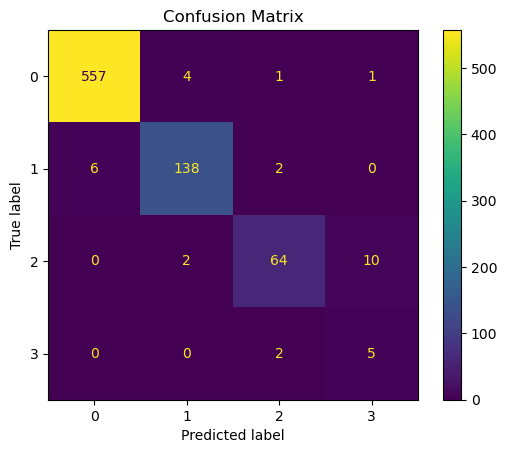

In [20]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Saving the LR Model

In [21]:
# Save the best model pipeline
joblib.dump(best_pipeline, 'best_logreg_model.pkl')

print("\nBest Logistic Regression model has been saved successfully.")


Best Logistic Regression model has been saved successfully.
